_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: Artemii Shlychhkov, Arne Gittel, Elias Seiffert

# Coding Lab 4

If needed, download the data files ```nds_cl_4_*.csv``` from ILIAS and save it in the subfolder ```../data/```. Use a subset of the data for testing and debugging, ideally focus on a single cell (e.g. cell number x). The spike times and stimulus conditions are read in as pandas data frames. You can solve the exercise by making heavy use of that, allowing for many quite compact computationis. If you need help on that, there is lots of [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html) and several good [tutorials](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python#gs.L37i87A) are available online. Of course, converting the data into classical numpy arrays is also valid.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt

from scipy import signal as signal
from typing import Tuple

from statsmodels.stats.multitest import multipletests

import itertools

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-06-04 12:41:36CEST

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

sklearn: 1.4.1.post1

matplotlib: 3.8.3
scipy     : 1.12.0
pandas    : 2.2.1
numpy     : 1.26.4
seaborn   : 0.13.2

Watermark: 2.4.3



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [3]:
spikes = pd.read_csv("../data/nds_cl_4_spiketimes.csv")  # neuron id, spike time
stims = pd.read_csv("../data/nds_cl_4_stimulus.csv")  # stimulus onset in ms, direction

stimDur = 2000.0  # in ms
nTrials = 11  # number of trials per condition
nDirs = 16  # number of conditions
deltaDir = 22.5  # difference between conditions

stims["StimOffset"] = stims["StimOnset"] + stimDur

In [4]:
spikes.head()

,Neuron,SpikeTimes
0,1,19.900000
1,1,29.866667
2,1,44.733333
3,1,55.033333
4,1,85.800000


In [5]:
stims.head()

,StimOnset,Dir,StimOffset
0,15570,270.0,17570.0
1,19022,45.0,21022.0
2,22592,112.5,24592.0
3,26095,225.0,28095.0
4,29431,180.0,31431.0


We require some more information about the spikes for the plots and analyses we intend to make later. With a solution based on dataframes, it is natural to compute this information here and add it as additional columns to the `spikes` dataframe by combining it with the `stims` dataframe. We later need to know which condition (`Dir`) and trial (`Trial`) a spike was recorded in, the relative spike times compared to stimulus onset of the stimulus it was recorded in (`relTime`) and whether a spike was during the stimulation period (`stimPeriod`). But there are many options how to solve this exercise and you are free to choose any of them.

In [6]:
# you may add computations as specified above
spikes["Dir"] = np.nan  #  add a new column to store the direction of the stimulus
spikes["relTime"] = np.nan  #  add a new column to store the relative time of the spike
spikes["Trial"] = np.nan  #  add a new column to store the trial number
spikes["stimPeriod"] = (
    np.nan
)  #  add a new column to store if the spike is within the stimulus period

dirs = np.unique(stims["Dir"])  #  get the unique directions
trialcounter = np.zeros_like(dirs)  #  initialize the trial counter

for i, row in stims.iterrows():  #  iterate over the rows of the stims dataframe
    trialcounter[
        dirs == row["Dir"]
    ] += 1  #  increment the trial counter for the current direction

    i0 = spikes["SpikeTimes"] > row["StimOnset"]  # spike time is after stimulus onset
    i1 = (
        spikes["SpikeTimes"] < row["StimOffset"]
    )  # spike time is before stimulus OFFset

    select = i0.values & i1.values  # select spikes that are within the stimulus period

    spikes.loc[select, "Dir"] = row["Dir"]  #  assign the direction to the spikes
    spikes.loc[select, "Trial"] = trialcounter[dirs == row["Dir"]][
        0
    ]  #  assign the trial number to the spikes
    spikes.loc[select, "relTime"] = (
        spikes.loc[select, "SpikeTimes"] - row["StimOnset"]
    )  #  assign the relative time to the spikes
    spikes.loc[select, "stimPeriod"] = (
        True  #  assign the flag to the spikkes if they are within the stimulus period
    )

spikes = spikes.dropna()  #  drop all rows that have NaN values

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_54362/695389936.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  spikes.loc[select, "stimPeriod"] = (


In [7]:
spikes.head()

,Neuron,SpikeTimes,Dir,relTime,Trial,stimPeriod
514,1,15739.000000,270.0,169.000000,1.0,True
515,1,15776.566667,270.0,206.566667,1.0,True
516,1,15808.466667,270.0,238.466667,1.0,True
517,1,15821.900000,270.0,251.900000,1.0,True
518,1,15842.966667,270.0,272.966667,1.0,True


## Task 1: Plot spike rasters

In a raster plot, each spike is shown by a small tick at the time it occurs relative to stimulus onset. Implement a function `plotRaster()` that plots the spikes of one cell as one trial per row, sorted by conditions (similar to what you saw in the lecture). Why are there no spikes in some conditions and many in others?

If you opt for a solution without a dataframe, you need to change the interface of the function.

*Grading: 2 pts*


In [8]:
def plotRaster(spikes: pd.DataFrame, neuron: int):
    """plot spike rasters for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    spikes_neuron = spikes[spikes["Neuron"] == neuron]

    fig, ax = plt.subplots(nDirs, 1, figsize=(6, 5), sharex=True, sharey="all")

    for i, dir in enumerate(dirs):
        for j in range(1, nTrials + 1):
            ax[i].scatter(
                spikes_neuron[
                    (spikes_neuron["Dir"] == dir) & (spikes_neuron["Trial"] == j)
                ]["relTime"],
                j
                * np.ones_like(
                    spikes_neuron[
                        (spikes_neuron["Dir"] == dir) & (spikes_neuron["Trial"] == j)
                    ]["relTime"]
                ),
                color="black",
                s=0.5,
            )

        ax[i].set_ylabel("{:.0f}".format(dir) + "°", size=5.5)

        ax[i].set_yticks([])
    plt.xlabel("Time [ms]")
    plt.suptitle(f"Neuron {neuron}")
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)

    # -------------------------------------------------
    # Write a raster plot function for the data (2 pts)
    # -------------------------------------------------

    # insert your code here
    # stim direction should be on the y-axis and time on the x-axis
    # you can use plt.scatter or plt.plot to plot the responses to each stim

Show examples of different neurons. Good candidates to check are 28, 29, 36 or 37. 

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_54362/3112078105.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


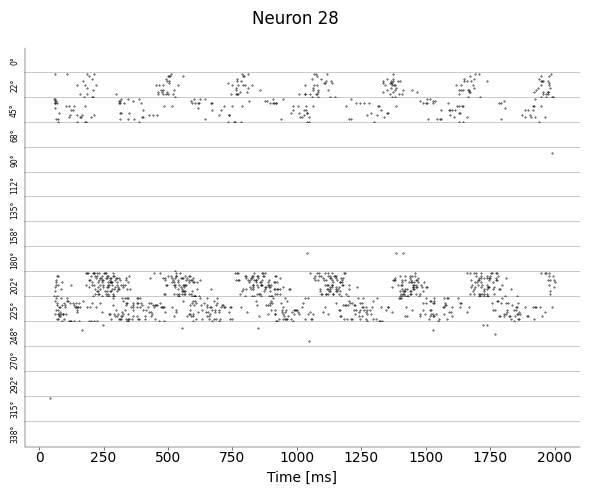

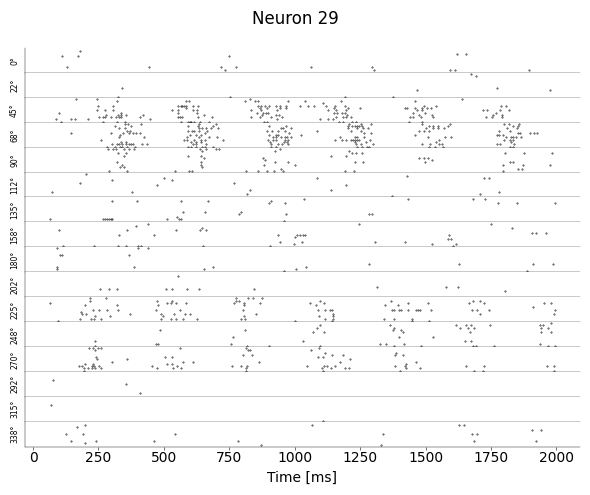

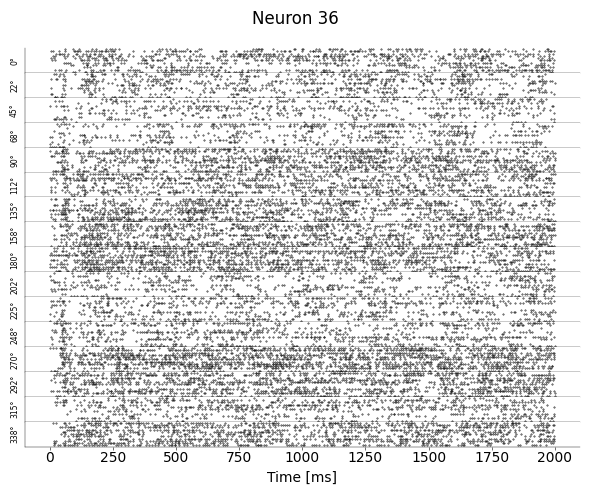

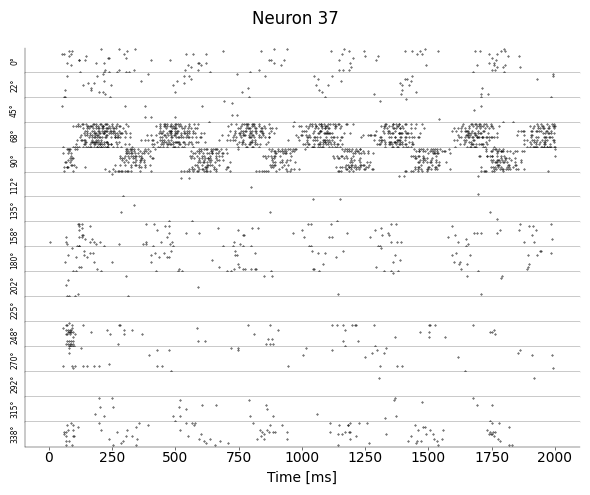

In [9]:
plotRaster(spikes, 28)
plotRaster(spikes, 29)
plotRaster(spikes, 36)
plotRaster(spikes, 37)

## Task 2: Plot spike density functions

Compute an estimate of the spike rate against time relative to stimulus onset. There are two ways:
* Discretize time: Decide on a bin size, count the spikes in each bin and average across trials. 
* Directly estimate the probability of spiking using a density estimator with specified kernel width. 

Implement one of them in the function `plotPsth()`. If you use a dataframe you may need to change the interface of the function.


*Grading: 2 pts*


#### Define the function to find the optimal width of the gaussian kernel for spike times as described in (Shimazaki & Shinimoto, 2010)

In [10]:
def optimal_width(sigmas: np.ndarray, spike_times: np.ndarray, plot: bool = False):
    """Find the optimal width of the gaussian kernel for spike times as described in (Shimazaki & Shinimoto, 2010)

    Parameters
    ----------
    sigmas: np.ndarray
        Array of sigma values to test
    spike_times: np.ndarray
        Array of superimposed spike times

    Returns
    -------
    float
        Optimal sigma value
    """

    C_list = []
    C = 0
    for sigma in sigmas:
        for i in range(len(spike_times)):
            for j in range(i + 1, len(spike_times)):
                diff = spike_times[i] - spike_times[j]
                term1 = np.exp(-(diff**2) / (4 * sigma**2))
                term2 = 2 * np.sqrt(2) * np.exp(-(diff**2) / (2 * sigma**2))
                C += term1 - term2
        C *= 2 / sigma  # multiply by 2 divided by sigma
        C += len(spike_times) / sigma  #  add the number of spikes divided by sigma
        C /= 2 * np.sqrt(np.pi) * nTrials**2  #  divide by the number of trials squared
        C_list.append(C)
    min_idx = np.argmin(C_list)
    min_sigma = sigmas[min_idx]
    if plot:
        plt.plot(sigmas, C_list, c="k", label="Cost function")
        plt.title("Cost function")
        plt.xlabel(r"$\sigma$")
        plt.ylabel(r"$\hat{C}$($\sigma$)")
        plt.axvline(min_sigma, c="r", label=r"Optimal $\sigma$")
        plt.legend()
        plt.show()
    return min_sigma

#### Example of optimal sigma usage for spike density estimation

(1252,)
(402, 6)
(402,)


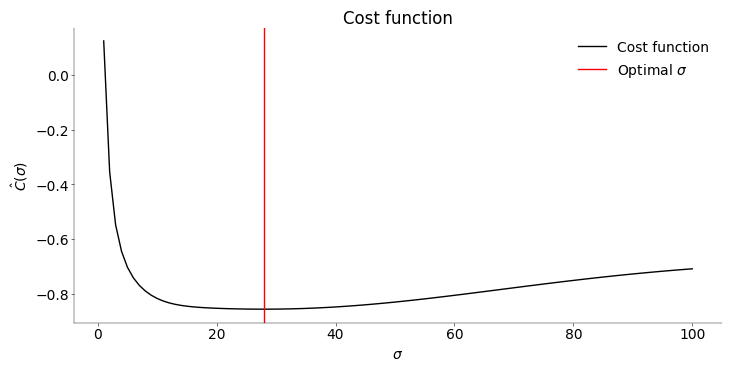

Optimal sigma: 28.0


In [11]:
from scipy.ndimage import gaussian_filter1d

# find non-empty directions for neuron 28
neuron = 28
dirs = np.unique(spikes[spikes["Neuron"] == neuron]["Dir"])

# get superimposed spike times for neuron 28 and direction 225 for all trials

spikes_225 = spikes[(spikes["Neuron"] == neuron) & (spikes["Dir"] == 225)]

print(spikes[spikes["Neuron"] == neuron]["relTime"].shape)
print(spikes_225.shape)

spikes_225_times = spikes_225["relTime"].values
print(spikes_225_times.shape)


# create a superimposed spike train for neuron 28 and direction 225
spike_train = np.zeros(2000)

spike_train[spikes_225_times.astype(int)] = 1


# find optimal width for the Gaussian kernel
sigmas = np.linspace(1, 100, 100)
sigma_225 = optimal_width(sigmas, spikes_225_times, plot=True)
print("Optimal sigma:", sigma_225)

# create a gaussian kernel
# kernel = signal.windows.gaussian(100, sigma_225)

# convolve spike times with the kernel
# spike_density = np.convolve(spike_train, kernel, mode="same")

# use scipy's gaussian_filter1d
spike_density = gaussian_filter1d(spike_train, sigma=sigma_225)

Text(0.5, 0, 'Time (ms)')

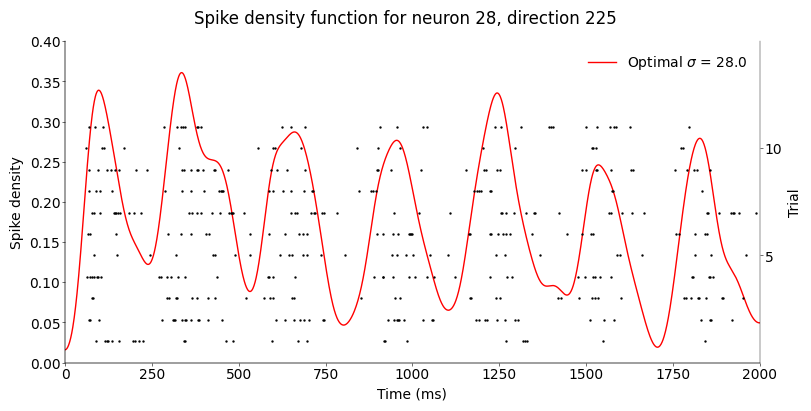

In [12]:
fig, ax_1 = plt.subplots(figsize=(8, 4))
ax_2 = ax_1.twinx()
ax_1.plot(spike_density, label=rf"Optimal $\sigma$ = {sigma_225}", c="red")

# adjust y-label such that density is spikes per ms


ax_1.set_ylim(0, 0.4)
ax_1.set_ylabel("Spike density")
# add legend with optimal sigma
ax_1.legend()

ax_2.set_ylim(0, 15)
ax_2.set_xlim(0, 2000)
ax_1.set_xlabel("Time (ms)")
ax_2.set_yticks([5, 10])
ax_2.set_ylabel("Trial")
for j in range(1, nTrials + 1):
    ax_2.scatter(
        spikes_225[spikes_225["Trial"] == j]["relTime"],
        j * np.ones_like(spikes_225[spikes_225["Trial"] == j]["relTime"]),
        color="black",
        s=2,
    )

# Show the right y-axis for ax_2
ax_2.spines["right"].set_visible(True)
ax_2.yaxis.set_label_position("right")
ax_2.yaxis.tick_right()


plt.suptitle("Spike density function for neuron 28, direction 225")
plt.xlabel("Time (ms)")

In [13]:
def plotPSTH(spikes: pd.DataFrame, neuron: int, sigmas: np.ndarray):
    """Plot PSTH for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    #
    # find non-empty directions for the neuron
    dirs = np.unique(spikes[spikes["Neuron"] == neuron]["Dir"])

    fig, ax = plt.subplots(dirs.size, 1, figsize=(6, 8), sharey=True)
    plt.suptitle(f"SDF for neuron {neuron}")

    for i, dir in enumerate(dirs):
        spikes_dir = spikes[
            (spikes["Neuron"] == neuron) & (spikes["Dir"] == dir)
        ]  # get spikes for the direction
        spike_train = np.zeros(
            int(spikes_dir["relTime"].max() + 1)
        )  # create a spike train
        spike_train[spikes_dir["relTime"].astype(int)] = (
            1  # set the spike train to 1 at the spike times
        )

        optimal_sigma = optimal_width(sigmas, spikes_dir["relTime"].values, plot=False)

        # kernel = signal.windows.gaussian(100, optimal_sigma)
        spike_density = gaussian_filter1d(spike_train, sigma=optimal_sigma)

        # ax[i].set_title(f" {dir}°", size=6, pad=-10)
        sub_ax = ax[i].twinx()

        for j in range(1, nTrials + 1):
            sub_ax.scatter(
                spikes_dir[spikes_dir["Trial"] == j]["relTime"],
                j * np.ones_like(spikes_dir[spikes_dir["Trial"] == j]["relTime"]),
                color="black",
                s=1,
            )
        sub_ax.set_yticks([5, 10])
        sub_ax.set_ylabel("Trial", size=6)
        sub_ax.tick_params(axis="y", size=6, labelsize=6)
        sub_ax.set_xticks([])
        sub_ax.set_ylim(0, 20)

        ax[i].plot(
            spike_density, color="red", label=rf"Optimal $\sigma$ = {optimal_sigma}"
        )
        ax[i].set_yticks([0.5])
        ax[i].tick_params(
            axis="y",
            size=6,
            labelsize=6,
        )
        ax[i].legend() if i == 0 else None
        ax[i].set_ylabel(f"{dir}°", size=6)
        ax[i].set_xticks(np.arange(0, 2000, 500)) if i == dirs.size - 1 else None
        ax[i].set_xlabel("Time (ms)") if i == dirs.size - 1 else None
        # ax[i].set_ylabel("Spike Density", size=6) if i == dirs.size // 2 else None

        ax[i].set_xlim(0, 750)
        # ax[i].set_ylim(0, np.max(spike_density) + 0.05)
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.01)

    plt.show()
    # --------------------------------
    # Implement one of the spike rate estimates (1 pt)
    # ------------------------------------------------

    # ---------------------------------------------
    # Plot the obtained spike rate estimates (1 pt)
    # ---------------------------------------------

    # plot should look similar to `plotRaster`
    # you can plot use plt.hist for each direction, but much cleaner
    # is to only plot bin centers vs bin heights using plt.plot

Show examples of different neurons. Good candidates to check are 28, 29, 36 or 37. 

/var/folders/g_/dvk6nf6n4w71vr5_mf4f1zdm0000gn/T/ipykernel_54362/555901316.py:77: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


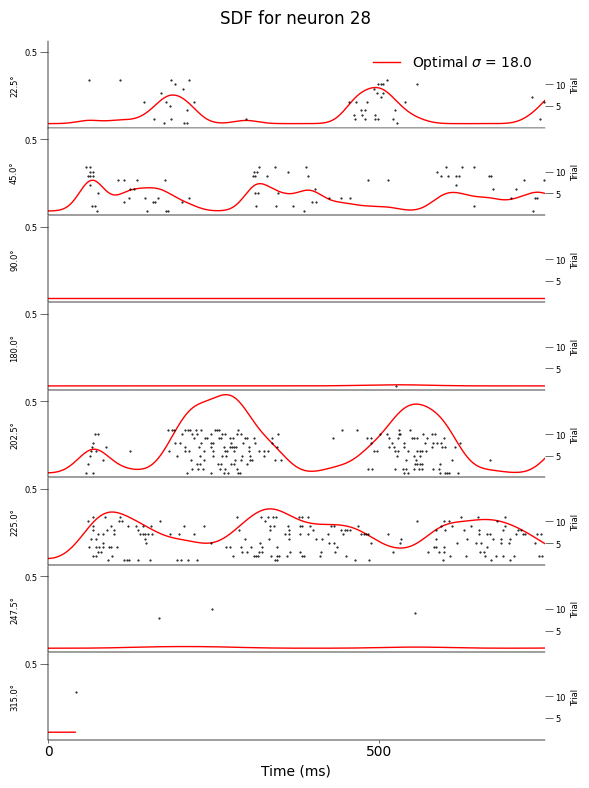

In [14]:
plotPSTH(spikes, 28, np.linspace(1, 50, 50))
# plotPSTH(spikes, 29, np.linspace(1, 50, 50))
# plotPSTH(spikes, 36, np.linspace(1, 50, 50))
# plotPSTH(spikes, 37, np.linspace(1, 50, 50))

## Task 3: Fit and plot tuning functions

The goal is to visualize the activity of each neuron as a function of stimulus direction. First, compute the spike counts of each neuron for each direction of motion and trial.  The result should be a matrix `x`, where $x_{jk}$ represents the spike count of the $j$-th response to the $k$-th direction of motion (i.e. each column contains the spike counts for all trials with one direction of motion).	If you used dataframes above, the `groupby()` function allows to implement this very compactely. Make sure you don't loose trials with zero spikes though. Again, other implementations are completely fine.

Fit the tuning curve, i.e. the average spike count per direction, using a von Mises model. To capture the non-linearity and direction selectivity of the neurons, we will fit a modified von Mises function:

$$ f(\theta) = \exp(\alpha + \kappa (\cos (2*(\theta-\phi))-1) + \nu (\cos (\theta-\phi)-1))$$

Here, $\theta$ is the stimulus direction. Implement the von Mises function in `vonMises()` and plot it to understand how to interpret its parameters $\phi$, $\kappa$, $\nu$, $\alpha$. Perform a non-linear least squares fit using a package/function of your choice. Implement the fitting in `tuningCurve()`. 

Plot the average number of spikes per direction, the spike counts from individual trials as well as your optimal fit.

Select two cells that show nice tuning to test you code.

*Grading: 3 pts*

In [15]:
def vonMises(θ: np.ndarray, α: float, κ: float, ν: float, ϕ: float) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # insert your code here

    # -----------------------------------
    # Implement the Mises model (0.5 pts)
    # -----------------------------------
    f = np.exp(
        α
        + κ * (np.cos(np.deg2rad(2 * (θ - ϕ))) - 1)
        + ν * np.cos(np.deg2rad(θ - ϕ) - 1)
    )
    return f

Plot the von Mises function while varying the parameters systematically.

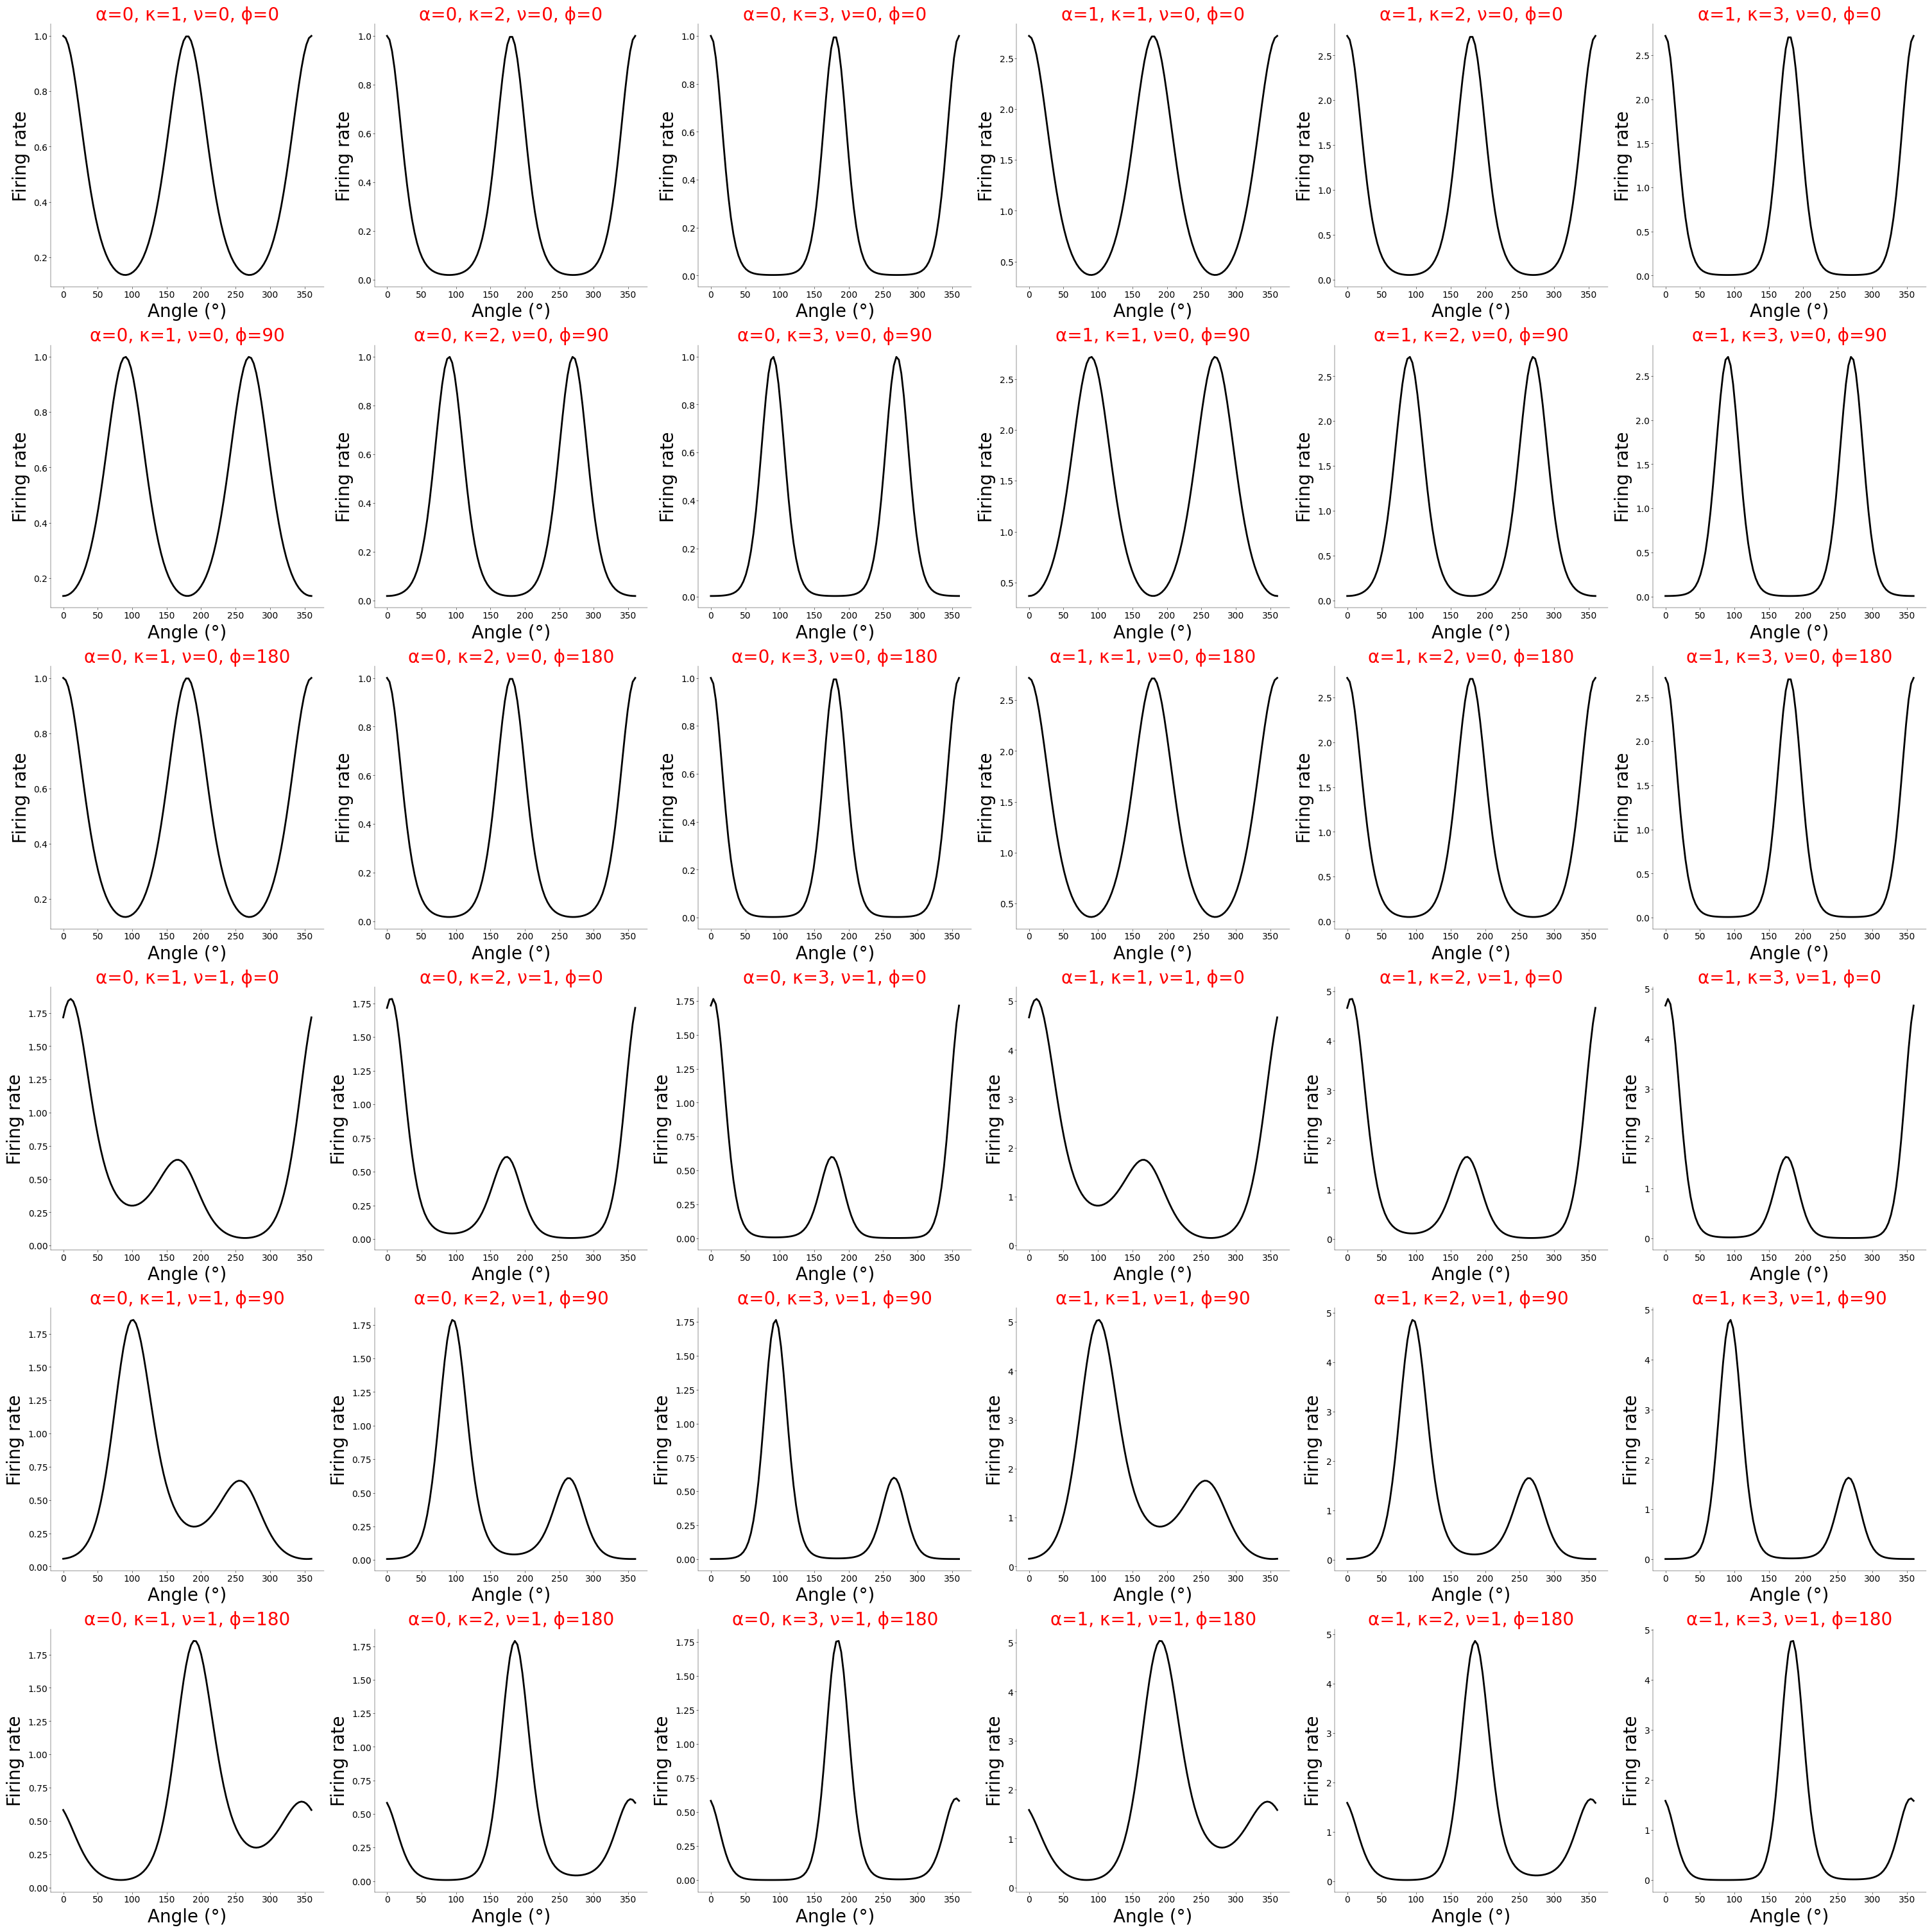

In [16]:
# --------------------------------------------------------------------------------
# plot von Mises curves with varying parameters and explain what they do (0.5 pts)
# --------------------------------------------------------------------------------
# angles in degrees
θ = np.linspace(0, 360, 100)

# parameters: α, κ, ν, ϕ

# α: baseline firing rate
# κ: tuning width
# ν: modulation depth

# ϕ: preferred direction

# plot von Mises curves with varying parameters

number_of_curves = 19
fig, ax = plt.subplots(6, 6, figsize=(30, 30))

i = 0

for α, κ, ν, ϕ in itertools.product([0, 1], [1, 2, 3], [0, 1], [0, 90, 180]):
    f = vonMises(θ, α, κ, ν, ϕ)
    # print(i % 6, int(i // 6))
    ax[i % 6][i // 6].plot(
        θ, f, label=f"α={α}, κ={κ}, ν={ν}, ϕ={ϕ}", linewidth=2, c="black"
    )
    ax[i % 6][i // 6].set_title(f"α={α}, κ={κ}, ν={ν}, ϕ={ϕ}", size=20, c="red")
    ax[i % 6][i // 6].set_xlabel("Angle (°)", size=20)
    ax[i % 6][i // 6].set_ylabel("Firing rate", size=20)

    i += 1

In [17]:
def tuningCurve(counts: np.ndarray, dirs: np.ndarray, show: bool = True) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.


    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """

    # compute mean spike count for each direction
    mean_counts = np.zeros_like(dirs)
    std = np.zeros_like(dirs)
    print()
    print(mean_counts.shape)
    for i, dir in enumerate(dirs):
        mean_counts[i] = np.mean(counts[dirs == dir])
        std[i] = np.std(counts[dirs == dir])

    # fit von Mises tuning curve to the data

    # initial guess for the parameters
    p0 = [1, 1, 1, 0]

    # fit the tuning curve

    p, _ = opt.curve_fit(vonMises, dirs, mean_counts, p0, method="lm")

    if show == True:
        # -----------------------------------------------
        # plot the data and fitted tuning curve (0.5 pts)
        # -----------------------------------------------

        fig, ax = plt.subplots(figsize=(7, 5))
        x = np.arange(np.min(dirs), np.max(dirs))
        # ax.plot(dirs, mean_counts, "o", label="Data", color="black")
        ax.errorbar(
            dirs,
            mean_counts,
            yerr=std,
            fmt="o",
            label="Mean spike count",
            color="black",
            capsize=2,
        )
        ax.plot(x, vonMises(x, *p), label="Fit", color="red")
        ax.set_xlabel("Direction (°)")
        ax.set_ylabel("Mean spike count")
        ax.legend()

        # add a box around the legend
        ax.legend(frameon=True, framealpha=1)

        # the plot should contain both the data and the fitted curve
        # using seaborn makes this really easy

        return
    else:
        return p

Plot tuning curve and fit for different neurons. Good candidates to check are 28, 29 or 37. 

In [18]:
def get_data(spikes, neuron):
    spk_by_dir = (
        spikes[spikes["Neuron"] == neuron]
        .groupby(["Dir", "Trial"])["stimPeriod"]
        .sum()
        .astype(int)
        .reset_index()
    )

    dirs = spk_by_dir["Dir"].values
    counts = spk_by_dir["stimPeriod"].values

    # because we count spikes only when they are present, some zero entries in the count vector are missing
    for i, Dir in enumerate(np.unique(spikes["Dir"])):
        m = nTrials - np.sum(dirs == Dir)
        if m > 0:
            dirs = np.concatenate((dirs, np.ones(m) * Dir))
            counts = np.concatenate((counts, np.zeros(m)))

    idx = np.argsort(dirs)
    dirs_sorted = dirs[idx]  # sorted dirs
    counts_sorted = counts[idx]

    return dirs_sorted, counts_sorted


(176,)


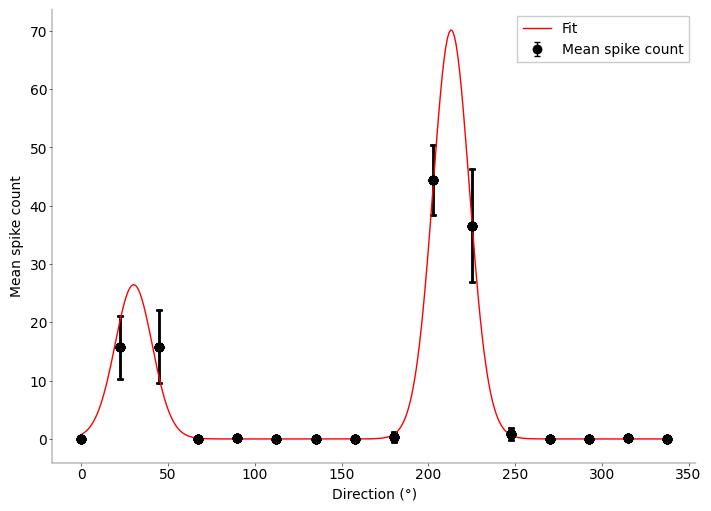

In [19]:
# ---------------------------------------------------------
# plot tuning curve and fit for different neurons (0.5 pts)
# ---------------------------------------------------------

dirs, counts = get_data(spikes, 28)
tuningCurve(counts, dirs)
# add plot


(176,)


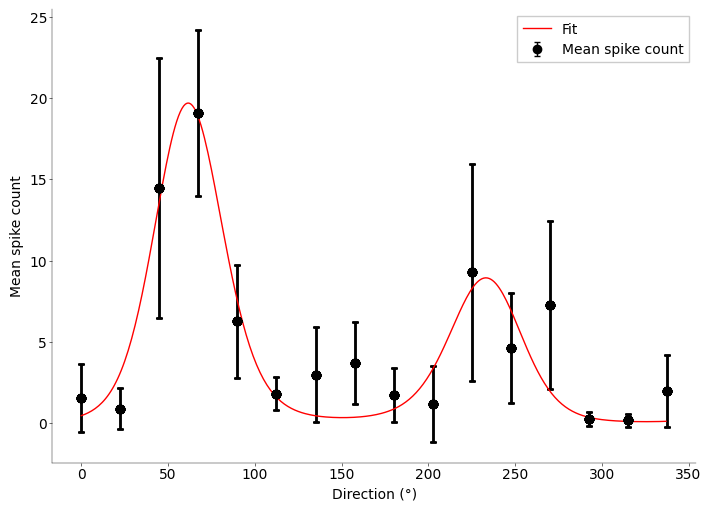

In [20]:
dirs, counts = get_data(spikes, 29)
tuningCurve(counts, dirs)
# add plot


(176,)


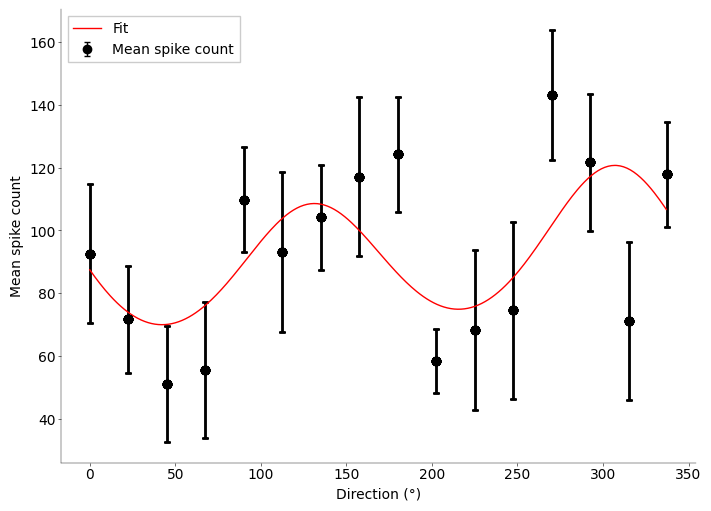

In [21]:
dirs, counts = get_data(spikes, 36)
# add plot
tuningCurve(counts, dirs)


(176,)


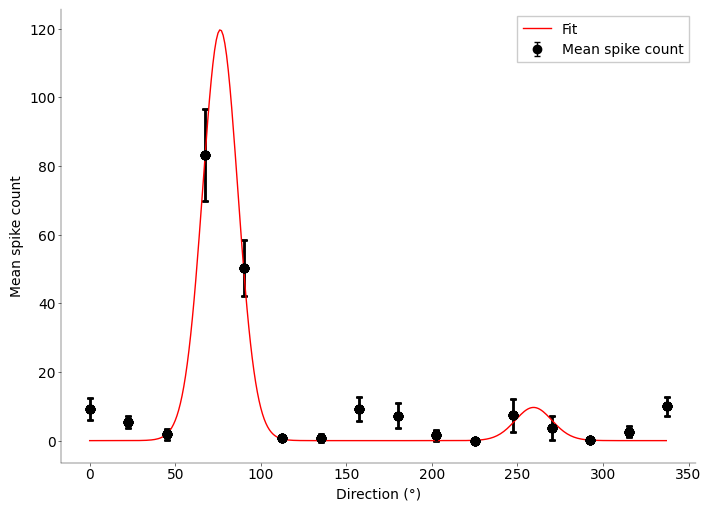

In [22]:
dirs, counts = get_data(spikes, 37)
tuningCurve(counts, dirs)
# add plot


(176,)


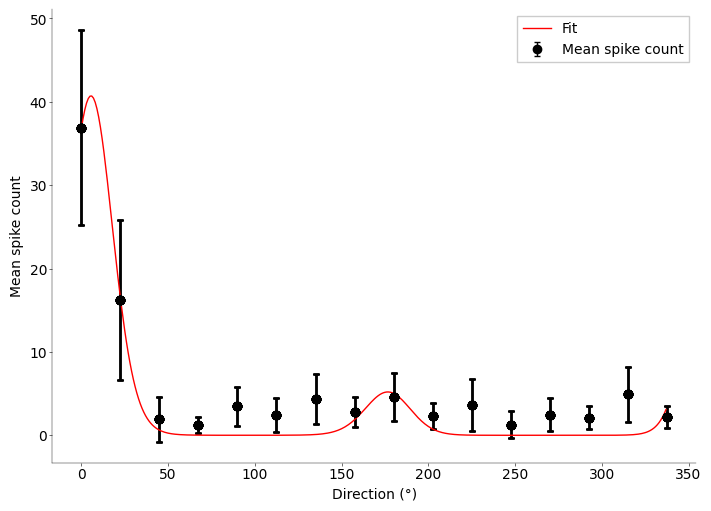

In [23]:
dirs, counts = get_data(spikes, 32)
tuningCurve(counts, dirs)
# add plot

## Task 4: Permutation test for direction tuning

Implement a permutation test to quantitatively assess whether a neuron is direction/orientation selective. To do so, project the vector of average spike counts, $m_k=\frac{1}{N}\sum_j x_{jk}$ on a complex exponential with two cycles, $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). Denote the projection by $q=m^Tv$. The magnitude $|q|$ tells you how much power there is in the $\psi$-th fourier component. 

Estimate the distribution of |q| under the null hypothesis that the neuron fires randomly across directions by running 1000 iterations where you repeat the same calculation as above but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x). The fraction of iterations for which you obtain a value more extreme than what you observed in the data is your p-value. Implement this procedure in the function ```testTuning()```. 

Illustrate the test procedure for one of the cells from above. Plot the sampling distribution of |q| and indicate the value observed in the real data in your plot. 

How many cells are tuned at p < 0.01?

*Grading: 3 pts*


In [24]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
) -> Tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """

    # insert your code here

    # -------------------------------
    # calculate m, nu and q (0.5 pts)
    # -------------------------------
    rng = np.random.default_rng(random_seed)

    nu = np.exp(1j * psi * np.deg2rad(dirs))
    mean_counts = np.zeros_like(dirs)
    for i, dir in enumerate(dirs):
        mean_counts[i] = np.mean(counts[dirs == dir])

    q = mean_counts.T @ nu

    # -------------------------------------------------------------------------
    # Estimate the distribution of q under the H0 and obtain the p value (1 pt)
    # -------------------------------------------------------------------------
    qdistr = np.zeros(niters, dtype=complex)

    for iter in range(niters):
        rng.shuffle(dirs)
        mean_counts = np.zeros_like(dirs)
        for i, dir in enumerate(dirs):
            mean_counts[i] = np.mean(counts[dirs == dir])

        nu = np.exp(1j * psi * np.deg2rad(dirs))
        qdistr[iter] = mean_counts.T @ nu

    # ensure reproducibility using a random number generator

    # perform the t test and get p values
    import scipy.stats

    ttest = scipy.stats.ttest_1samp(qdistr, q)

    p = ttest.pvalue

    # hint: access random functions of this generator

    if show == True:
        # -------------------------------
        # plot the test results (0.5 pts)
        # -------------------------------
        fig, ax = plt.subplots(figsize=(7, 4))

        sns.histplot(np.abs(qdistr), ax=ax, kde=True, color="black")
        ax.axvline(np.abs(q), color="red", label="Observed |q|")
        plt.legend()

        # you can use sns.histplot for the histogram
    else:
        return p, q, qdistr

Show null distribution for the example cell:

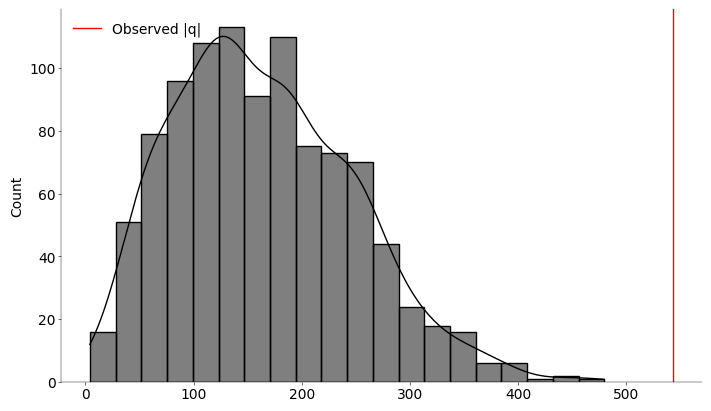

In [25]:
# ------------------------------------------------------------
# Plot null distributions for example cells 28 & 29. (0.5 pts)
# ------------------------------------------------------------

dirs, counts = get_data(spikes, 28)
testTuning(counts, dirs, show=True)
# add plot

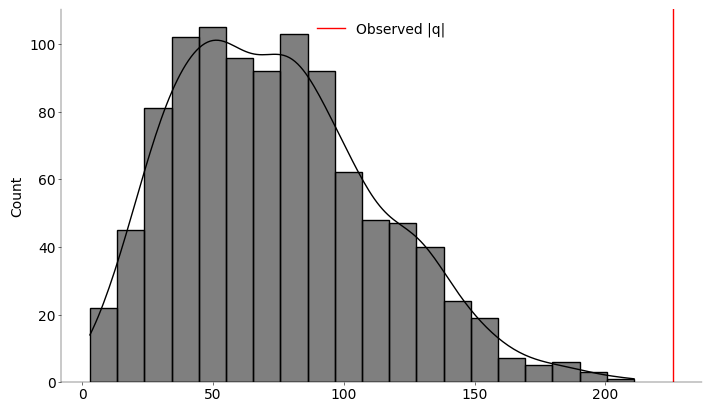

In [26]:
dirs, counts = get_data(spikes, 29)
testTuning(counts, dirs, show=True)

# add plot

Test all cells for orientation and direction tuning

In [27]:
# -------------------------------------------------------
# Test cells for orientation / direction tuning (0.5 pts)
# -------------------------------------------------------

# collect p values for orientation / direction selectivity

p_values = np.zeros((spikes["Neuron"].nunique(), 2))

for i, neuron in enumerate(spikes["Neuron"].unique()):
    dirs, counts = get_data(spikes, neuron)
    p_values[i, 0], _, _ = testTuning(counts, dirs, psi=1)
    p_values[i, 1], _, _ = testTuning(counts, dirs, psi=2)

Number of direction tuned neurons:

In [28]:
# count cells with p < 0.01 (which ones are they?)
print("Direction tuned Cells with p < 0.01:")
significant_direction_neurons = []
for i in range(p_values.shape[0]):
    if p_values[i, 0] < 0.01:
        significant_direction_neurons.append(spikes["Neuron"].unique()[i])

print(significant_direction_neurons)
# print(spikes["Neuron"].unique()[np.sum(p_values[:, 0] < 0.01, axis=1) > 0])

Direction tuned Cells with p < 0.01:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]


Number of orientation tuned neurons:

In [29]:
# count cells with p < 0.01 (which ones are they?)
print("Orientation tuned Cells with p < 0.01:")
significant_orientation_neurons = []
for i in range(p_values.shape[0]):
    if p_values[i, 1] < 0.01:
        significant_orientation_neurons.append(spikes["Neuron"].unique()[i])

print(significant_orientation_neurons)
# print(spikes["Neuron"].unique()[np.sum(p_values < 0.01, axis=1) > 0])

Orientation tuned Cells with p < 0.01:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]


Correction af multitesting false discovery rate

In [30]:
# To correct the false discovery rate for multiple testing, we can use the Bonferroni correction

bonferroni_corrected_p_value = 0.01 / spikes["Neuron"].nunique()
print(
    "Bonferroni corrected threshhold for significance: ", bonferroni_corrected_p_value
)

# count cells with p < bonferonni corrected p value in regards of direction
significant_direction_neurons_bf = []
for i in range(p_values.shape[0]):
    if p_values[i, 0] < bonferroni_corrected_p_value:
        significant_direction_neurons_bf.append(spikes["Neuron"].unique()[i])

print("Direction tuned Cells", significant_direction_neurons_bf)

# count cells with p < bonferonni corrected p value in regards of orientation
significant_orientation_neurons_bf = []
for i in range(p_values.shape[0]):
    if p_values[i, 1] < bonferroni_corrected_p_value:
        significant_orientation_neurons_bf.append(spikes["Neuron"].unique()[i])

print("Orientation tuned Cells", significant_orientation_neurons_bf)

Bonferroni corrected threshhold for significance:  0.00024390243902439024
Direction tuned Cells [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
Orientation tuned Cells [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]


In [31]:
# Alternativly we can use the Benjamini-Hochberg correction for multiple testing to control the false discovery rate (which is not as conservative as the Bonferroni correction)


# direction
p_values_d = p_values[:, 0]

# orientation
p_values_o = p_values[:, 1]

# Perform the Benjamini-Hochberg correction
reject_d, pvals_corrected_d, _, _ = multipletests(
    p_values_d, alpha=0.01, method="fdr_bh"
)
reject_o, pvals_corrected_o, _, _ = multipletests(
    p_values_o, alpha=0.01, method="fdr_bh"
)


# Reshape the reject array back to the original shape of p_values
reject_reshaped_d = reject_d.reshape(p_values[:, 0].shape)

reject_o_reshaped = reject_o.reshape(p_values[:, 1].shape)

# Print the results with neuron IDs
print("Direction tuned Cells with p < 0.01 after Benjamini-Hochberg correction:")
print(reject_reshaped_d)

print("Orientation tuned Cells with p < 0.01 after Benjamini-Hochberg correction:")
print(reject_o_reshaped)

Direction tuned Cells with p < 0.01 after Benjamini-Hochberg correction:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
Orientation tuned Cells with p < 0.01 after Benjamini-Hochberg correction:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
